# Задание

Для данного задания предлагается использовать полный датасет MovieLens (https://grouplens.org/datasets/movielens/latest/)  
Необходимо построить векторные представления (эмбеддинги) пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбеддингу пользователя искать похожие эмбеддинги фильмов и рекомендовать ему их.  
При выполнении задания обратите внимание на:

1. Разбиение данных на обучение и валидацию, обоснование
2. Выбор и обоснование метрики. 
3. Разработка архитектуры нейронной сети с пояснениями
4. Обучение и валидация
5. Решение должно быть воспроизводимым, в формате Juper Notebook (Google Colab / файл на Github) с подробными пояснениями на каждом шаге

В ответе прикрепить ссылку на Google Colab notebook решение (проверьте настройки приватности или ссылку на Github репозиторий с Jupyter Notebook решением.

# Решение

Здесь использован метод коллаборативной фильтрации. Цель:
1. Сопоставить идентификатор пользователя с "вектором пользователя" с помощью матрицы эмбеддингов
2. Сопоставить идентификатор пользователя с "вектором фильмов" с помощью матрицы эмбеддингов
3. Вычислить скалярное произведение между вектором пользователя и вектором фильма, чтобы оценить близость этих векторов, а следовательно получить оценку соответствия между пользователем и фильмом (предсказанный рейтинг).
4. Обучить

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 0.7

# Скачивание

https://files.grouplens.org/datasets/movielens/ml-latest.zip

In [2]:
movielens_data_file_url = (
    "https://files.grouplens.org/datasets/movielens/ml-latest.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


# Кодирование значений userId и MovieId в качестве последовательности целых чисел

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

# Данные для нормализации
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Число пользователей: {num_users}, Число фильмов: {num_movies}, Мин рейтинг: {min_rating}, Макс рейтинг: {max_rating}")

Число пользователей: 283228, Число фильмов: 53889, Мин рейтинг: 0.5, Макс рейтинг: 5.0


In [5]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,307,3.5,1256677221,0,0
1,1,481,3.5,1256677456,0,1
2,1,1091,1.5,1256677471,0,2
3,1,1257,4.5,1256677460,0,3
4,1,1449,4.5,1256677264,0,4


# Разбиение данных на обучение и валидацию

In [6]:
# Перемешиваем
df = df.sample(frac=1, random_state=42)
# Матрица x - колонки user и movie (после кодировки)
x = df[["user", "movie"]].values

# Вектор y - нормализованные значения рейтинга (нормализуем от 0 до 1)
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Делим данные на трейн и тест в соотношении 90% на трейн, 10% на тест
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Создание модели
Мы встраиваем пользователей и фильмы в 50-мерные векторы-эмбединги.

Далее вычисляем оценку соответствия между эмбедингами пользователя и фильма с помощью скалярного произведения, прибавляем смещение на векторы фильмов и пользователей. Результат с помощью сигмоиды масштабируем в интервале [0, 1] (поскольку наши рейтинги нормированы на этот диапазон).  

В данном конкретном случае модель RecommenderNet предсказывает оценку фильма пользователем по непрерывной шкале от 0 до 1, что можно рассматривать как задачу бинарной классификации, так как сигмоидная функция активации используется в модели, чтобы заставить предсказанный рейтинг находиться в диапазоне от 0 до 1.

Так как мы свели задачу к бинарной классификации,  в качестве функции потерь используется BinaryCrossentropy

Функция потерь BinaryCrossentropy принимает в качестве входных данных предсказание модели (значение вероятности в диапазоне [0, 1]) и истинную метку (также значение в диапазоне [0, 1]).


In [7]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        
        x = dot_user_movie + user_bias + movie_bias
        
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Обучение
Чтобы избежать переобучение, создадим lr_scheduler, learning rate будем уменьшать по экспоненте

In [8]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4096,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[callback], 
)

Epoch 1/5
6099/6099 [==============================] - 127s 20ms/step - loss: 0.6256 - accuracy: 0.1447 - val_loss: 0.6144 - val_accuracy: 0.1469 - lr: 1.0000e-04
Epoch 2/5
6099/6099 [==============================] - 68s 11ms/step - loss: 0.6099 - accuracy: 0.1470 - val_loss: 0.6067 - val_accuracy: 0.1480 - lr: 1.0000e-04
Epoch 3/5
6099/6099 [==============================] - 65s 11ms/step - loss: 0.6045 - accuracy: 0.1487 - val_loss: 0.6032 - val_accuracy: 0.1501 - lr: 1.0000e-04
Epoch 4/5
6099/6099 [==============================] - 65s 11ms/step - loss: 0.6016 - accuracy: 0.1500 - val_loss: 0.6009 - val_accuracy: 0.1509 - lr: 9.0484e-05
Epoch 5/5
6099/6099 [==============================] - 63s 10ms/step - loss: 0.5998 - accuracy: 0.1508 - val_loss: 0.5996 - val_accuracy: 0.1515 - lr: 8.1873e-05


# Графики

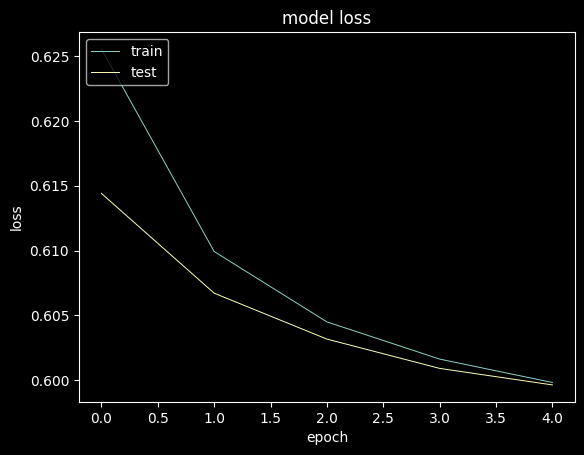

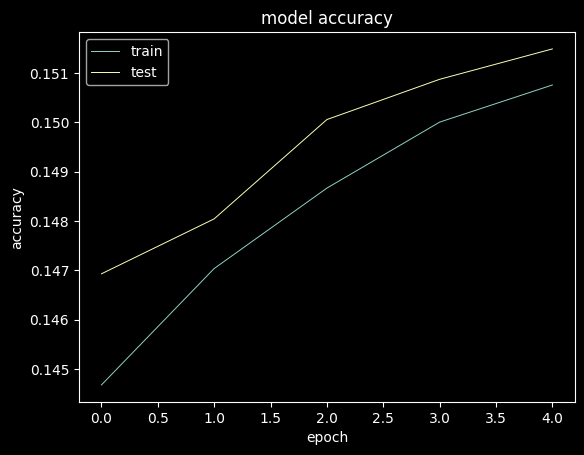

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Покажем топ 10 рекомендаций для случайного пользователя

In [18]:
# Читаем датасет movies.csv
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Случайным образом выбераем пользователя, для которого будут генерироваться рекомендации
user_id = df.userId.sample(1).iloc[0]

# Фильтруем фильмы, просмотренные выбранным пользователем
movies_watched_by_user = df[df.userId == user_id]

# Фильтруем фильмы, не просмотренные выбранным пользователем
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

# Преобразовываем идентификаторы фильмов в соответствующие им кодированные значения и создайте список непросмотренных фильмов
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# Получаем код пользователя и создаем массив, в котором напротив кода выбранного пользователя располагаем коды непросмотренных фильмов
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

# Предсказываем рейтинги для фильмов, не просмотренных пользователем, используя обученную модель
ratings = model.predict(user_movie_array).flatten()

# Выбираем индексы 10 лучших рейтингов
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Получаем идентификаторы фильмов, рекомендованных к просмотру, используя топ 10 индексов рейтинга
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# Печатаем результаты
print(f"Showing recommendations for user: {user_id}")
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

1678/1678 [==============================] - 5s 3ms/step
Showing recommendations for user: 130662
Movies with high ratings from user
--------------------------------
American History X (1998) : Crime|Drama
American Beauty (1999) : Drama|Romance
Detachment (2011) : Drama
Big Short, The (2015) : Drama
Nocturnal Animals : Drama|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Casablanca (1942) : Drama|Romance
One Flew Over the Cuckoo's Nest (1975) : Drama
12 Angry Men (1957) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
